# Spambase microlab

A brief summary of the dataset can be found here https://www.openml.org/d/44

## The business problem

Spam emails can easily be associated to phishing emails which aim to take advantage of you, your co-workers, and society. Every day an individual at a company gets a convincing email that their password is outdated or hot singles in their area want to mingle. One click and either their business identity is compromised, leading to attacks of fraud in the form of [business email compromise](https://www.fbi.gov/scams-and-safety/common-scams-and-crimes/business-email-compromise). Or worse, botnet recruitment and malware attacks. All bad things.

## This dataset

This dataset, [spambase](https://www.openml.org/d/44), is a collection of submitted work and personal emails labeled as either spam or not spam.

There are 48 features that are word frequency scores (word_freq_WORD), they are continuous numbers between 0,100 calculated using - (100*(number of times the WORD appears in the email)/total number of words in e-mail). Why these 48? I don't know.

6 features are character frequency scores (char_freq_CHAR), also continuous between 0,100. However CHAR is not a word, it is a set of 3 characters. These features are calculated as (100 * (number of CHAR occurences) / total characters in e-mail). Upon inspection of char_freq_%21, spam emails ranked highly averaging a score of .513713 while  averaged .109984. So it's probably informative though a deeper dive into feature importance should be done. Whoosh descriptive stats whoosh

There are 3 others to finish out our predictive features all dealing with capital letters CUZ THIS LOOKS LIKE SPAM!!!
- capital_run_length_average, average length of uninterrupted capital sequences
- capital_run_length_longest, length of the single longest string of capital letters in the email
- capital_run_length_total, total number of capital letters in the email

And the target (Target) is either a 1 (Spam) or 0 (normal)


## Time to model

In [30]:
#import the goods

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import eli5
import pdpbox
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance
import numpy as np
import sys
from pdpbox import pdp, get_dataset, info_plots

#if any packages fail to import (eli5 for example) try running !pip install "package-name" in its own cell block
# e.x !pip install eli5

#I reset this here because later we expand it to limitless and don't want to crash the system on repeat runs
pd.set_option('display.max_rows', 10)

In [2]:
#if your version isn't .24.1 or later run pip install -U scikit-learn in an anaconda terminal
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.1.


In [3]:
#scikit has this cool feature where you can directly pull datasets from the openML site
#so no need for downloading csv's to make something like a ipynb file work

X, y = fetch_openml(data_id=44, return_X_y = True)

#this retrieves the dataset from openML and stores the feature set into X and the targets into y
#return_X_y is a parameter that returns the data split into two tuples (data, target)

In [4]:
#shape of features, 4601 entries and 57 columns
X.shape

(4601, 57)

In [5]:
def data_get(id_num):
    '''input the id number of the dataset on openML you want,
    function then returns as X (data), y(target) from openML.'''
    X, y = fetch_openml(data_id=id_num, return_X_y = True)
    return X, y
#spambase is id 44
X, y = data_get(44)

In [6]:
def prelim_describe():
    '''Simply prints the shape of X and y'''
    print('Features have shape', X.shape,'\n ',
          'Targets have shape',y.shape)
prelim_describe()

Features have shape (4601, 57) 
  Targets have shape (4601,)


In [7]:
X_frame = pd.DataFrame(X)
X_frame.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0


In [8]:
y_frame = pd.DataFrame(y)
y_frame.head()

,class
0,1
1,1
2,1
3,1
4,1


In [9]:
#Xy_frame = X_frame.assign(0, 'Target', y_frame, True)

In [10]:
def frame_maker(X,y):
    '''This turns features X and targets y into two seperate dataframes'''
    X_frame = pd.DataFrame(X)
    y_frame = pd.DataFrame(y)
    return X_frame, y_frame
X_frame, y_frame = frame_maker(X,y)

In [11]:
def frame_combiner(x,y):
    '''This takes frame X and copies it to insert frame y,
    where frame X are your features and frame y is the target'''
    final_frame = x
    final_frame.insert(0, 'Target', y, True)
    final_frame
    return final_frame

In [12]:
Xy_frame = frame_combiner(X_frame, y_frame)

In [13]:
#Now we have our final dataframe!

Xy_frame

,Target,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0
1,1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.0,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.0,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0
3,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.0,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0
4,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.0,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,...,0.0,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3.0,88.0
4597,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4.0,14.0
4598,0,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6.0,118.0
4599,0,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,...,0.0,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5.0,78.0


## Do we need to dataclean?

Typically once the data is organized how you like, or even before. Here I chose after... It is a good idea to do basic data inspection and see if it needs to be cleaned, imputed, manipulated in any way.

In [14]:
pd.DataFrame(Xy_frame).isnull().sum()

Target                        0
word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
                             ..
char_freq_%24                 0
char_freq_%23                 0
capital_run_length_average    0
capital_run_length_longest    0
capital_run_length_total      0
Length: 58, dtype: int64

Our data contains no null values, meaning either the data is _complete and accurate_, or has already had cleaning done, for example all null values may have already been imputed to 0. We may never know.

But we will take it as is and not worry about that.

## Feature Engineering

Once your data is clean and formatted how you'd like it's time to select features. If there is an abundance of predictors you may wish to prune out uninformative ones. Basic descriptive models and statistics can help you out here.

One method to feature engineer is _permutation importance_ the concept is simple. All other things held constant, what if we just shuffle around the features one at a time among the rows, swapping values? What happens? Does accuracy go up? Down? This could shine a light on important predictive variables and some that aren't so important, helping you build better deployable models.



In [15]:
#redundant steps
X_full = Xy_frame.drop(['Target'], axis=1)
y_full = Xy_frame.Target

# Preliminary Modeling

Our data contains a classification problem, whether an email is spam or legitimate.



In [16]:
Xy_frame

,Target,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0
1,1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.0,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.0,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0
3,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.0,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0
4,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.0,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,...,0.0,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3.0,88.0
4597,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4.0,14.0
4598,0,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6.0,118.0
4599,0,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,...,0.0,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5.0,78.0


In [17]:
#splitting the data 80 20
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_full, y_full, test_size=.2, train_size=.8)

In [18]:
#classification tree with max depth 5
rf_classifier = sklearn.ensemble.RandomForestClassifier(max_depth=5, random_state = 1)

In [19]:
#fitting
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [20]:
#testing
preds = rf_classifier.predict(X_test)
preds_df = pd.DataFrame(preds)

In [21]:
accuracy_score(y_test, preds)

0.9174809989142236

In [22]:
#getting accuracy score, 
def get_acc(max_depth, X_train, X_test, y_train, y_test):
    rf_classifier = sklearn.ensemble.RandomForestClassifier(max_depth = max_depth, random_state = 1)
    rf_classifier.fit(X_train, y_train)
    preds = rf_classifier.predict(X_test)
    acc_score = accuracy_score(y_test, preds)
    return acc_score

In [23]:
for max_depth in [5, 10, 15]:
    my_acc = get_acc(max_depth, X_train, X_test, y_train, y_test)
    print("at depth:",max_depth,"acc =",my_acc)   

at depth: 5 acc = 0.9174809989142236
at depth: 10 acc = 0.9315960912052117
at depth: 15 acc = 0.9359391965255157


In [24]:
#checking frequency of %21 among positively labeled emails (spam)
#Over 51% of spam emails contain some amount of %21

check_char_freq = Xy_frame.loc[Xy_frame['Target'] == '1', 'char_freq_%21']
pd.set_option('display.max_rows', None)
pd.DataFrame(check_char_freq).mean()

char_freq_%21    0.513713
dtype: float64

In [25]:
#cchecking character frequency of %21 among normal emails
#less than 11% of normal emails contain %21

check_char_freq0 = Xy_frame.loc[Xy_frame['Target'] == '0', 'char_freq_%21']
pd.set_option('display.max_rows', None)
pd.DataFrame(check_char_freq0).mean()

char_freq_%21    0.109984
dtype: float64

## Feature Selection

Once your data is clean and formatted how you'd like it's time to select features. If there is an abundance of predictors you may wish to prune out uninformative ones. Basic descriptive models and statistics can help you out here.

### Permutation Importance

One method to feature engineer is _permutation importance_ the concept is simple. All other things held constant, what if we just shuffle around the features one at a time among the rows, swapping values? What happens? Does accuracy go up? Down? This could shine a light on important predictive variables and some that aren't so important, helping you build better deployable models.


In [26]:
perm_model_1 = PermutationImportance(rf_classifier, random_state = 1).fit(X_train, y_train)
eli5.show_weights(perm_model_1, feature_names = X_train.columns.to_list())

Weight,Feature
0.0163 ± 0.0015,char_freq_%24
0.0142 ± 0.0036,char_freq_%21
0.0120 ± 0.0020,word_freq_remove
0.0096 ± 0.0034,word_freq_hp
0.0063 ± 0.0028,word_freq_free
0.0063 ± 0.0041,capital_run_length_average
0.0061 ± 0.0017,word_freq_george
0.0041 ± 0.0014,word_freq_hpl
0.0038 ± 0.0021,word_freq_our
0.0035 ± 0.0011,word_freq_edu


The weights on the left show how much model accuracy decreased when the feature was randomly shuffled. The +- shows standard deviation of accuracy change from one shuffling to the next.

We can see that character frequency scores of %24 and %21 are relatively important and should probably be left in in a successful model. We could continue to run permutation importance on models with different sets of features to determine any more pruning that should be done.

### Partial Dependence Plots

Permutation importance illustrates how important a feature is in the metric of _accuracy_, which is nice. However it does not neccessarily tell you anything about _how_ a feature interacts within the model. Something you may like to be able to explain to a managerial audience. 

Partial Dependence Plots can illustrate that how.

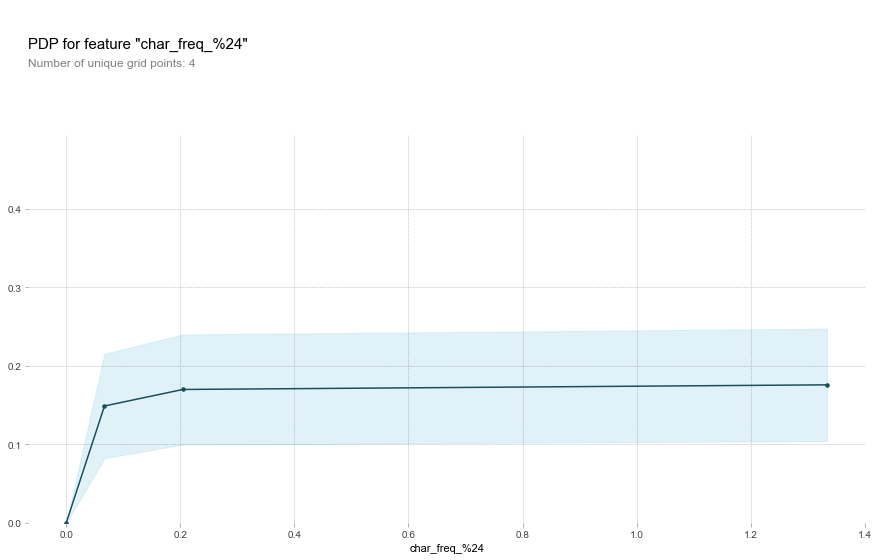

In [36]:
#here we are just creating a list of names to use in the pdp method
feature_names = X_train.columns.to_list()
#similar to permutation importance, the actual partial dependence plot is first stored inside a variable before using
#plt to actaully show it

pdp_char_freq_24 = pdp.pdp_isolate(model=rf_classifier, dataset=X_test, model_features=feature_names, feature='char_freq_%24')

pdp.pdp_plot(pdp_char_freq_24, 'char_freq_%24')
plt.show()

The Y-axis shows the change in prediction at a given X-value, in this case char_freq_%24, or the percent of total characters that match the given set (%24)

As we can see in the plot - increasing the number of characters that match %24 in a given email increases the chances of it being labeled as spam. We can also see that once roughly 20% of characters match the set the feature stops adding predictive power.

Let's do another one.

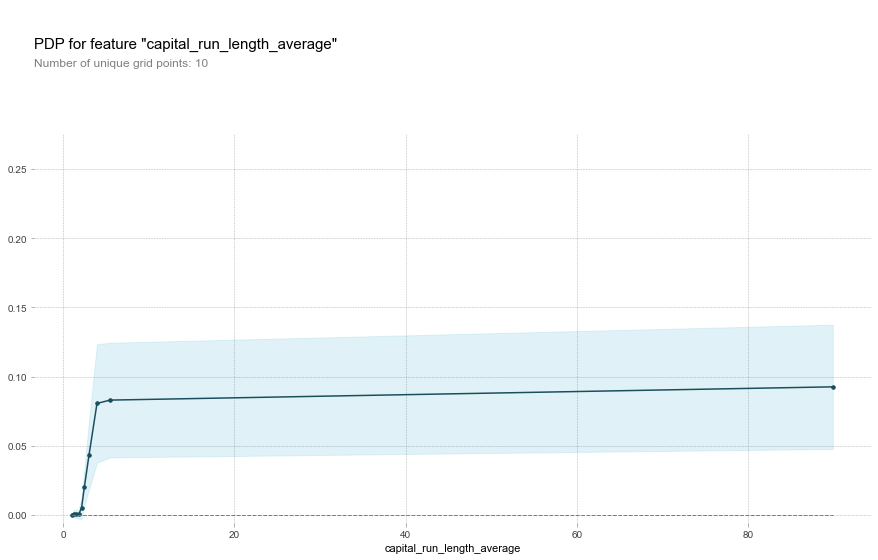

In [37]:
pdp_capital_rla = pdp.pdp_isolate(model=rf_classifier, dataset=X_test, model_features=feature_names, feature='capital_run_length_average')

pdp.pdp_plot(pdp_capital_rla, 'capital_run_length_average')
plt.show()
